# Gaussian generative models for handwritten digit classification

Recall that the 1-NN classifier yielded a 3.09% test error rate on the MNIST data set of handwritten digits. We will now see that a Gaussian generative model does almost as well, while being significantly faster and more compact.

## 1. Set up notebook and load in data

As usual, we start by importing the required packages and data. For this notebook we will be using the *entire* `MNIST` dataset. The code below defines some helper functions that will load `MNIST` onto your computer.

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt 
import gzip, os, sys
import numpy as np
from scipy.stats import multivariate_normal

if sys.version_info[0] == 2:
    from urllib import urlretrieve
else:
    from urllib.request import urlretrieve

In [40]:
# Function that downloads a specified MNIST data file from Yann Le Cun's website
def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
    print("Downloading %s" % filename)
    urlretrieve(source + filename, filename)

# Invokes download() if necessary, then reads in images
def load_mnist_images(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1,784)
    return data

def load_mnist_labels(filename):
    if not os.path.exists(filename):
        download(filename)
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), np.uint8, offset=8)
    return data

Now load in the training set and test set

In [41]:
## Load the training set
train_data = load_mnist_images('train-images-idx3-ubyte.gz')
train_labels = load_mnist_labels('train-labels-idx1-ubyte.gz')

## Load the testing set
test_data = load_mnist_images('t10k-images-idx3-ubyte.gz')
test_labels = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

The function **displaychar** shows a single MNIST digit. To do this, it first has to reshape the 784-dimensional vector into a 28x28 image.

In [51]:
def displaychar(image):
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.axis('off')
    plt.show()

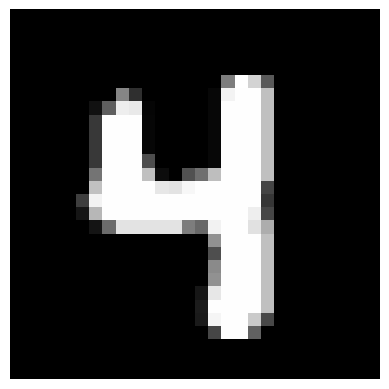

In [52]:
displaychar(train_data[58])

The training set consists of 60,000 images. Thus `train_data` should be a 60000x784 array while `train_labels` should be 60000x1. Let's check.

In [44]:
train_data.shape, train_labels.shape

((60000, 784), (60000,))

## 2. Fit a Gaussian generative model to the training data

**<font color="magenta">For you to do:</font>** Define a function, **fit_generative_model**, that takes as input a training set (data `x` and labels `y`) and fits a Gaussian generative model to it. It should return the parameters of this generative model; for each label `j = 0,1,...,9`, we have:
* `pi[j]`: the frequency of that label
* `mu[j]`: the 784-dimensional mean vector
* `sigma[j]`: the 784x784 covariance matrix

This means that `pi` is 10x1, `mu` is 10x784, and `sigma` is 10x784x784.

We have already seen how to fit a Gaussian generative model in the Winery example, but now there is an added ingredient. <font color="magenta">The empirical covariances are very likely to be singular (or close to singular), which means that we won't be able to do calculations with them</font>. Thus it is important to **regularize** these matrices. The standard way of doing this is to add `cI` to them, where `c` is some constant and `I` is the 784-dimensional identity matrix. (To put it another way, we compute the empirical covariances and then increase their diagonal entries by some constant `c`.)

This modification is guaranteed to yield covariance matrices that are non-singular, for any `c > 0`, no matter how small. But this doesn't mean that we should make `c` as small as possible. Indeed, `c` is now a parameter, and by setting it appropriately, we can improve the performance of the model. We will study **regularization** in greater detail over the coming weeks.

Your routine needs to choose a good setting of `c`. Crucially, this needs to be done using the training set alone. So you might try setting aside part of the training set as a validation set, or using some kind of cross-validation.

In [45]:
from sklearn.model_selection import train_test_split

In [87]:
def compute_log_likelihood(X, mu, sigma, c):
    log_probs = []
    smoothed_sigma = {j: sigma[j] + c * np.eye(sigma[j].shape[0]) for j in range(10)}

    for j in range(10): 
        try:
            # Compute log-probability with the smoothed covariance matrix
            dist = multivariate_normal(mean=mu[j], cov=smoothed_sigma[j], allow_singular=False)
            log_probs.append(dist.logpdf(X))
        except np.linalg.LinAlgError:
            print(f"Singular matrix encountered for class {j}, adjusting regularization.")
            # If a singular matrix is encountered, apply more regularization
            smoothed_sigma[j] = sigma[j] + 1e-3 * np.eye(sigma[j].shape[0])  # Increase regularization
            dist = multivariate_normal(mean=mu[j], cov=smoothed_sigma[j], allow_singular=False)
            log_probs.append(dist.logpdf(X))

    return np.array(log_probs).T

In [88]:
# def compute_log_likelihood_no_smoothing(X, mu, sigma, c):
#     log_probs = []
#     #new_sigma = []

#     for j in range(10): 
#         try:
#             # Compute log-probability with the smoothed covariance matrix
#             dist = multivariate_normal(mean=mu[j], cov=sigma[j], allow_singular=False)
#             log_probs.append(dist.logpdf(X))
#         except np.linalg.LinAlgError:
#             print(f"Singular matrix encountered for class {j}, adjusting regularization.")
#             # If a singular matrix is encountered, apply more regularization
#             sigma[j] = sigma[j] + 1e-3 * np.eye(sigma[j].shape[0])  # Increase regularization
#             dist = multivariate_normal(mean=mu[j], cov=new_sigma[j], allow_singular=False)
#             log_probs.append(dist.logpdf(X))

#     return np.array(log_probs).T

In [89]:
def fit_generative_model(x,y):
    k = 10  # labels 0,1,...,k-1
    d = (x.shape)[1]  # number of features
    mu = np.zeros((k,d))
    sigma = np.zeros((k,d,d))
    pi = np.zeros(k)
    ###
    ### Your code goes here
    # split the training set of size 60000 into training set of 50000 and validation set of 10000
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=10000, random_state=7)

    # class probability computations
    class_counts = np.bincount(y_train)
    pi = class_counts / len(y_train)
    # print(X_train.shape)
    # print(class_counts)
    # print(pi)

    # compute mean and covariance matrix for each class
    mu = {}
    sigma = {}

    for j in range(k):
        class_data = X_train[y_train == j]
        mu[j] = np.mean(class_data, axis=0)
        sigma[j] = np.cov(class_data, rowvar=False)

    # grid search for best c
    candidate_c = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
    best_c = None
    lowest_val_error = float('inf')
    
    for c in candidate_c:
        log_probs = compute_log_likelihood(X_val, mu, sigma, c)
        predictions = np.argmax(np.log(pi) + log_probs, axis=1)
        val_error = np.mean(predictions != y_val)
        if val_error < lowest_val_error:
            lowest_val_error = val_error
            best_c = c
    
    print(f"Best c: {best_c}, Validation Error Rate : {lowest_val_error}")
    
    log_probs_test = compute_log_likelihood(test_data, mu, sigma, best_c)
    test_predictions = np.argmax(np.log(pi) + log_probs_test, axis=1)
    test_error = np.mean(test_predictions != test_labels)
    
    print(f"Test Error Rate: {test_error}")
    
    misclassified_indices = np.where(test_predictions != test_labels)[0]
    random_indices = np.random.choice(misclassified_indices, 5, replace=False)
    
    plt.figure(figsize=(10, 2))
    for i, idx in enumerate(random_indices):
        plt.subplot(1, 5, i + 1)
        plt.imshow(test_data[idx].reshape(28, 28), cmap='gray')
        plt.title(f"True: {test_labels[idx]} \nPred: {test_predictions[idx]}")
        plt.axis("off")
    plt.show()

    return(mu, sigma, pi)
    
    ###
    # Halt and return parameters
    #return mu, sigma, pi

Okay, let's try out your function. In particular, we will use **displaychar** to visualize the means of the Gaussians for the first three digits. You can try the other digits on your own.

Singular matrix encountered for class 0, adjusting regularization.
Singular matrix encountered for class 1, adjusting regularization.
Singular matrix encountered for class 2, adjusting regularization.
Singular matrix encountered for class 3, adjusting regularization.
Singular matrix encountered for class 4, adjusting regularization.
Singular matrix encountered for class 5, adjusting regularization.
Singular matrix encountered for class 6, adjusting regularization.
Singular matrix encountered for class 7, adjusting regularization.
Singular matrix encountered for class 8, adjusting regularization.
Singular matrix encountered for class 9, adjusting regularization.
Singular matrix encountered for class 0, adjusting regularization.
Singular matrix encountered for class 1, adjusting regularization.
Singular matrix encountered for class 5, adjusting regularization.
Singular matrix encountered for class 6, adjusting regularization.
Best c: 1, Validation Error Rate : 0.1658
Test Error Rate: 0.1

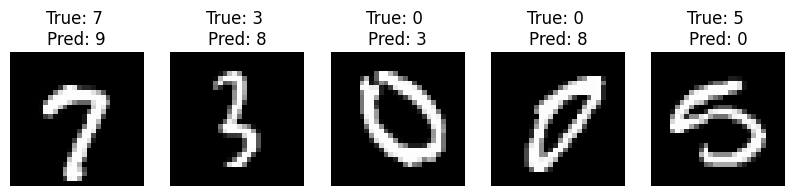

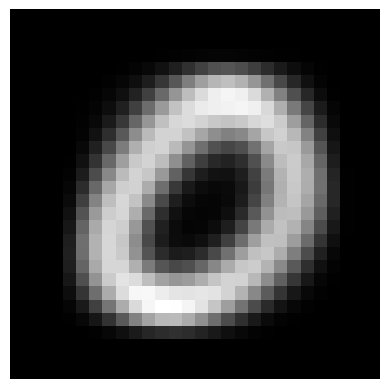

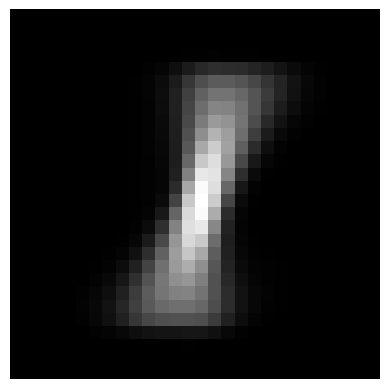

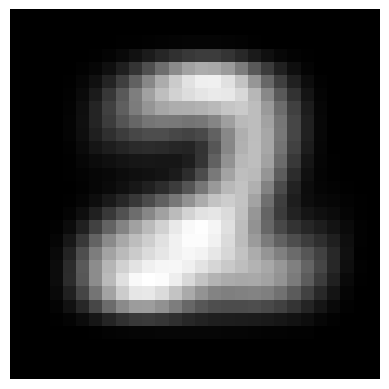

In [90]:
mu, sigma, pi = fit_generative_model(train_data, train_labels)
displaychar(mu[0])
displaychar(mu[1])
displaychar(mu[2])

## 3. Make predictions on test data

Now let's see how many errors your model makes on the test set.

In [91]:
# Compute log Pr(label|image) for each [test image,label] pair.
k = 10
score = np.zeros((len(test_labels),k))
for label in range(0,k):
    rv = multivariate_normal(mean=mu[label], cov=sigma[label])
    for i in range(0,len(test_labels)):
       score[i,label] = np.log(pi[label]) + rv.logpdf(test_data[i,:])
predictions = np.argmax(score, axis=1)
# Finally, tally up score
errors = np.sum(predictions != test_labels)
print("Your model makes " + str(errors) + " errors out of 10000")

LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

# Part a
## Split dataset into training and validation sets
randomly_shuffle_data()

train_set, validation_set = split_data(dataset, train_size=50000, val_size=10000)

## Compute class probabilities (πj) on the training set
class_counts = count_labels(train_set)

pi = {j: class_counts[j] / len(train_set) for j in range(10)}

## Fit a Gaussian to each class
for j in range(10):

    class_data = get_data_for_class(train_set, j)
    
    mu[j] = compute_mean(class_data)
    
    sigma[j] = compute_covariance(class_data)

## Add smoothing to the covariance matrix
best_c = None

lowest_validation_error = float("inf")

for c in candidate_values_of_c:

    smoothed_sigma = {j: sigma[j] + c * identity_matrix(784) for j in range(10)}
    
    # Evaluate on the validation set
    validation_error = compute_validation_error(validation_set, pi, mu, smoothed_sigma)
    
    if validation_error < lowest_validation_error:
        lowest_validation_error = validation_error
        best_c = c

## Use the chosen value of c to finalize the model
final_smoothed_sigma = {j: sigma[j] + best_c * identity_matrix(784) for j in range(10)}

# Classify test set digits
test_error, misclassified_indices = evaluate_on_test_set(test_set, pi, mu, final_smoothed_sigma)

# Display five randomly selected misclassified digits
randomly_sample_and_display(test_set, misclassified_indices, n=5)


# Part b

I used a single value of c for all ten classes. The value of c I got after testing these values: [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1] was 1.

# Part c

The test error rate when I used c = 1 was 0.1567.

# Part d

This was done above.

## 4. Quick exercises

*You will need to answer variants of these questions as part of this week's assignment*.

<font color="magenta">Exercise 1:</font> What happens if you do not regularize the covariance matrices?

<font color="magenta">Exercise 2:</font> What happens if you set the value of `c` too high, for instance to one billion? Do you understand why this happens?

<font color="magenta">Exercise 3:</font> What value of c did you end up using? How many errors did your model make on the training set?

<font color="magenta">If you have the time</font>: We have talked about using the same regularization constant `c` for all ten classes. What about using a different value of `c` for each class? How would you go about choosing these? Can you get better performance in this way?

# Exercise 1

If you don't regularize the covariance matrices, you get an error because the input matrix is not symmetric positive definite, which means it is a singular matrix.

# Exercise 2

When the value of c was set too high, like 1000000000, the error on the test set was extremely high. I'm not one hundred percent sure, but I believe that this happens because it can bias the model towards the independence assumption and can lead to oversmoothing. 

# Exercise 3

I used c=1, and it had an error rate of .1567 on the test set.

# Exercise 4

I don't have the time now, but I will try this in the future.